# WriteRight: An English dialect translator

**Summary**: Communication is challenging when people speak different dialects. In a business setting, this can result in lost time, sales, and ultimately revenue. Communication is such an extensive problem, that it is estimated ~$40B will be spent on translation services in 2018. Currently, machine learning based translation services focus on translations between different languages, thus there is a need for dialect translation services.

Here, I developed an English dialect translator to translate between American and British English. Feel free to explore the translator at [http://www.writeright.cc](http://www.writeright.cc).

### Data analysis details below:

I recently added large corpora of sentences to a Postgresql database. I want to use these data as new training data to see if we can do a better job of translating. Each corpus has millions of words and are specific to American and British dialects. Keep your fingers crossed...

First, lets see what we have in the database.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
from gensim import models, utils
from gensim.models import translation_matrix
import gensim

In [2]:
# Define a database name
# Set your postgres username
dbname = 'corpus'
username = 'dan' # change this to your username

In [3]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
from sqlalchemy import create_engine
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://dan@localhost/corpus


In [4]:
conn = None
conn = psycopg2.connect(database = dbname, user = username)
cur = conn.cursor()

# create table one by one

# close communication with the PostgreSQL database server
#cur.close()
# commit the changes
#conn.commit()

In [5]:
cur = conn.cursor()
cur.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
print (cur.fetchall())



[('training_data',)]


### Input data into Pandas

In [6]:
command = '''SELECT * 
             FROM training_data;
             '''

# Read in the data into Pandas
df = pd.read_sql_query(command, con=engine)



In [7]:
df.source.value_counts()

BNC     12736688
OANC      627803
Name: source, dtype: int64

In [8]:
df_non_dup = df.drop_duplicates()

I need to change 'BNC' and 'OANC' to number values. Later analyses require numerical rather than text data.

In [9]:
temp_replace = {'BNC':0, 'OANC': 1}
df_non_dup['source'] = df_non_dup['source'].replace(temp_replace)

/Users/dan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
df_non_dup.head()

,source,sentence
0,0,have you done much work
1,0,i've done some work
2,0,i've tried
3,0,good
4,0,to sort of


In [24]:
# tokenize the sentences

# I've tried the TweetTokenizer, which doesn't split contractions into two words, and the RegexpTokenizer, which does
# split contractions into two words. They ultimately have the same results. On a quick glance, it looks like 
# RegexpTokenizer might be more widely used, so I'm going to go with that.

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+') # matches letters or numbers

df_non_dup["tokens"] = df_non_dup["sentence"].apply(tokenizer.tokenize)
df_non_dup.head()


#from nltk.tokenize import TweetTokenizer
#tokenizer = TweetTokenizer()
#df_non_dup["tokens"] = df_non_dup["sentence"].apply(tokenizer.tokenize)
#df_non_dup.head()

/Users/dan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,source,sentence,tokens
0,0,have you done much work,"[have, you, done, much, work]"
1,0,i've done some work,"[i, ve, done, some, work]"
2,0,i've tried,"[i, ve, tried]"
3,0,good,[good]
4,0,to sort of,"[to, sort, of]"


The tokenizing removes punctuations, but it does not remove special characters like '@'. This could be an issue if this (or other) character is commonly used. I'm going to count how many times '@' is used in the data as a proxy for whether I need to be concerned about further data cleaning, or whether I can proceed with the data as they are for my first pass.

In [ ]:
tmp_n_at = sum(df_non_dup.sentence.str.contains('@'))
tmp_n_words = sum(len(df_non_dup.sentence.split()))

In [33]:
# proportion of words that contain '@'
print(tmp_n_at/tmp_n_words)

5.03935209662e-05


It is clear that '@' is very rare in the data and can probably be ignored. I'm going to assume this is true for most oddities in the data. As a result, I'll proceed with the current data (without more cleaning) for this iteration.

### Gensim comes with the ability to use "phrases" instead of words. Unfortunately, the phrasing, as implemented here, doesn't work unless an individual inputs the new word as 'first_second', which would never happen. So, I've commented out these sections and will re-run it without it.
Identify phrases that exist in our data.

In [14]:
#british_phrases = models.phrases.Phrases(df_non_dup.loc[df_non_dup['source'] == 0, 'tokens'])
#american_phrases = models.phrases.Phrases(df_non_dup.loc[df_non_dup['source'] == 1, 'tokens'])

Update the tokens with our newly identified phrases.

In [15]:
#df_non_dup.loc[df_non_dup['source']==0, 'tokens'].replace(british_phrases[df_non_dup.loc[df_non_dup['source']==0, 'tokens']], inplace=True)
#df_non_dup.loc[df_non_dup['source']==1, 'tokens'].replace(american_phrases[df_non_dup.loc[df_non_dup['source']==1, 'tokens']], inplace=True)

In [16]:
df_non_dup.tokens

0                               [have, you, done, much, work]
1                                   [i, ve, done, some, work]
2                                              [i, ve, tried]
3                                                      [good]
4                                              [to, sort, of]
6           [what, the, hell, i, was, supposed, to, do, with]
7                                    [what, were, you, doing]
8           [there, s, some, i, m, totally, totally, confu...
9                         [you, were, doing, differentiating]
10                                                [and, then]
11                                                     [yeah]
12          [leaving, it, and, then, going, back, to, it, ...
13                                             [some, of, it]
15          [no, no, i, don, t, know, what, i, ve, done, w...
16               [i, ve, been, concentrating, on, trying, to]
17                                                     [okay]
18      

Inspect our data a bit more.

In [34]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df_non_dup["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df_non_dup["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

Using TensorFlow backend.
/Users/dan/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


105049293 words total, with a vocabulary size of 446226
Max sentence length is 843


That is a little strange that there is a sentence with length 843. I suspect that somewhere in the data processing, a bunch of sentences got combined into a single sentence. This would only be an issue at the sentence boundaries where words from one sentence could be associated with words from a second sentence. I'm going to look at how many of the sentences appear to have this problem. If it is not a widespread problem, I'm going to proceed without digging into the problem much further.

(array([  2.26321100e+06,   3.70849800e+06,   2.11640200e+06,
          1.11177700e+06,   5.59508000e+05,   2.73699000e+05,
          1.32289000e+05,   6.39140000e+04,   3.16900000e+04,
          1.63790000e+04,   8.62600000e+03,   4.74000000e+03,
          2.75400000e+03,   1.70400000e+03,   1.04400000e+03,
          7.21000000e+02,   4.66000000e+02,   3.10000000e+02,
          2.24000000e+02,   1.83000000e+02,   1.37000000e+02,
          1.12000000e+02,   7.70000000e+01,   7.80000000e+01,
          5.30000000e+01,   4.70000000e+01,   4.10000000e+01,
          3.80000000e+01,   2.00000000e+01,   2.60000000e+01,
          1.80000000e+01,   1.90000000e+01,   1.50000000e+01,
          1.10000000e+01,   1.10000000e+01,   8.00000000e+00,
          3.00000000e+00,   1.20000000e+01,   6.00000000e+00,
          7.00000000e+00,   1.00000000e+01,   6.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   5.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   4.00000000e+00,
        

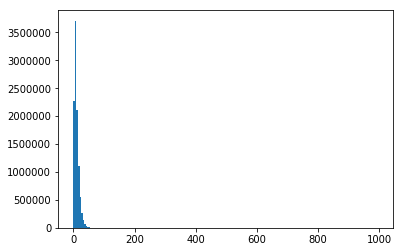

In [37]:
plt.hist(sentence_lengths, bins=range(0,1000,5))

Clearly, most sentences are short and the accidental combination of multiple sentences is likely not an issue. I'm going to proceed without further exploration into this 843 word sentence.

### Bag of words

In [19]:
british_vec = gensim.models.Word2Vec(df_non_dup.loc[df_non_dup['source'] == 0, 'tokens'], size=300)
american_vec = gensim.models.Word2Vec(df_non_dup.loc[df_non_dup['source'] == 1, 'tokens'], size=300)

Save/load the word vectors

In [39]:
#british_vec.wv.save("british_big")
#american_vec.wv.save("american_big")
british_vec = gensim.models.KeyedVectors.load('british_big')
american_vec = gensim.models.KeyedVectors.load('american_big')


Create word pairs that will serve as the "map" to connect the British and American vectors.

In [40]:
train_file = "training_words1000.txt" # from https://www.ef.edu/english-resources/english-vocabulary/top-1000-words/

with utils.smart_open(train_file, "r") as f:
    word_pair = [tuple(utils.any2unicode(line.lower()).strip().split()) for line in f]

In [41]:
transmat_us_to_uk = models.translation_matrix.TranslationMatrix(american_vec.wv, british_vec.wv)
transmat_us_to_uk.train(word_pair)
transmat_uk_to_us = models.translation_matrix.TranslationMatrix(british_vec.wv, american_vec.wv)
transmat_uk_to_us.train(word_pair)

Now I'm going to "validate" my model using text from Harry Potter and the Half-Blood Prince.

In [42]:
uk_words = []
us_words = []

#with utils.smart_open(train_file, "r") as f:
#    word_pair = [tuple(utils.any2unicode(line.lower()).strip().split()) for line in f]
header = True    
with open('harry_potter_half_blood_prince_comparisons.txt', 'r') as hp: # uk words are in the first column and us in second
    for line in hp:
        if header:
            header = False
        else:
            tmp_words = line.lower().split()
            uk_words.append(tmp_words[0])
            us_words.append(tmp_words[1])
    


Test American to British

In [43]:
def test_translation(original_words, translated_words, source_vec, destination_vec, number_to_return):
    correct = 0
    not_in_model = 0
    tmp_correct_index = []
    tmp_incorrect_index = []
    
    transmat = models.translation_matrix.TranslationMatrix(source_vec.wv, destination_vec.wv)
    transmat.train(word_pair)

    for i in range(len(original_words)): # using 1 instead of 0 because the list has a header
        try:
            output_dict = transmat.translate(original_words[i], topn=number_to_return, source_lang_vec=source_vec.wv, target_lang_vec=destination_vec.wv)
            #print(translated_words[i], output_dict[original_words[i]])
            if translated_words[i] in output_dict[original_words[i]]:
                correct += 1
                tmp_correct_index.append(i)
            else:
                tmp_incorrect_index.append(i)
        except:
            not_in_model += 1
    return([correct/len(original_words), not_in_model/len(original_words), tmp_correct_index, tmp_incorrect_index])


Test US to UK

In [44]:
# this prints the 
print(test_translation(us_words, uk_words, american_vec, british_vec, 5))
print(test_translation(us_words, uk_words, american_vec, british_vec, 10))
us_to_uk_correct, us_to_uk_missing, us_to_uk_correct_index, us_to_uk_incorrect_index = test_translation(us_words, uk_words, american_vec, british_vec, 10)

[0.3434343434343434, 0.09090909090909091, [0, 4, 5, 6, 9, 11, 12, 14, 17, 19, 25, 29, 31, 33, 34, 35, 41, 44, 47, 49, 52, 56, 58, 62, 67, 70, 72, 74, 83, 84, 90, 91, 94, 98], [1, 2, 3, 7, 8, 10, 15, 16, 18, 20, 23, 24, 26, 27, 30, 32, 36, 37, 38, 40, 42, 43, 45, 46, 48, 51, 53, 54, 55, 59, 60, 61, 63, 64, 65, 66, 68, 69, 71, 73, 75, 76, 77, 79, 80, 81, 82, 85, 86, 87, 88, 89, 92, 93, 95, 97]]
[0.42424242424242425, 0.09090909090909091, [0, 3, 4, 5, 6, 9, 11, 12, 14, 17, 19, 25, 29, 31, 33, 34, 35, 41, 44, 47, 49, 52, 53, 56, 58, 62, 64, 65, 67, 69, 70, 72, 74, 81, 83, 84, 85, 89, 90, 91, 94, 98], [1, 2, 7, 8, 10, 15, 16, 18, 20, 23, 24, 26, 27, 30, 32, 36, 37, 38, 40, 42, 43, 45, 46, 48, 51, 54, 55, 59, 60, 61, 63, 66, 68, 71, 73, 75, 76, 77, 79, 80, 82, 86, 87, 88, 92, 93, 95, 97]]


**US to UK translation results:**
When checking to see if the expected word was in the top **5 translations was identified 35%** and **43% when that was expanded to the top 10**.

Test UK to US

In [44]:
print(test_translation(uk_words, us_words, british_vec, american_vec, 5))
print(test_translation(uk_words, us_words, british_vec, american_vec, 10))
uk_to_us_correct, uk_to_us_missing, uk_to_us_correct_index, uk_to_us_incorrect_index = test_translation(uk_words, us_words, british_vec, american_vec, 10)

[0.1919191919191919, 0.050505050505050504, [2, 3, 4, 6, 7, 8, 10, 17, 47, 49, 51, 52, 70, 72, 83, 84, 90, 97, 98], [0, 1, 5, 9, 11, 12, 14, 15, 18, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96]]
[0.2828282828282828, 0.050505050505050504, [0, 2, 3, 4, 6, 7, 8, 10, 14, 17, 19, 25, 29, 31, 47, 49, 51, 52, 62, 70, 72, 73, 79, 83, 84, 90, 97, 98], [1, 5, 9, 11, 12, 15, 18, 20, 22, 23, 24, 26, 27, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 71, 74, 75, 76, 77, 78, 80, 81, 82, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96]]


**UK to US translation results:**
When checking to see if the expected word was in the top **5 translations was identified 19%** and **28% when that was expanded to the top 10**.

Count how many times each word was observed in the training data

In [45]:
# a function that counts the number of occurrences of a word in the 'tokens' column
def count_word_occurrences(tmp_word, tmp_source):
    total_count = 0
    tmp_df = df_non_dup.loc[df_non_dup['source'] == tmp_source]
    for sentence in tmp_df['sentence']:
        total_count += sentence.count(tmp_word)
    return(total_count)
    
    

How many times is each word observed in the data for the words we could translate and the words that we couldn't

In [58]:
incorrect_words_count_us_to_uk = []
for i in us_to_uk_incorrect_index:
    incorrect_words_count_us_to_uk.append([us_words[i], count_word_occurrences(us_words[i], 0), uk_words[i], count_word_occurrences(uk_words[i], 1)])

In [59]:
correct_words_count_us_to_uk = []
for i in us_to_uk_correct_index:
    correct_words_count_us_to_uk.append([us_words[i], count_word_occurrences(us_words[i], 0), uk_words[i], count_word_occurrences(uk_words[i], 1)])

In [61]:
count_of_good_translations = pd.DataFrame(correct_words_count_us_to_uk)
count_of_good_translations.columns = ['us_word', 'us_count', 'uk_word', 'uk_count']
count_of_good_translations['translated'] = 1

count_of_bad_translations = pd.DataFrame(incorrect_words_count_us_to_uk)
count_of_bad_translations.columns = ['us_word', 'us_count', 'uk_word', 'uk_count']
count_of_bad_translations['translated'] = 0

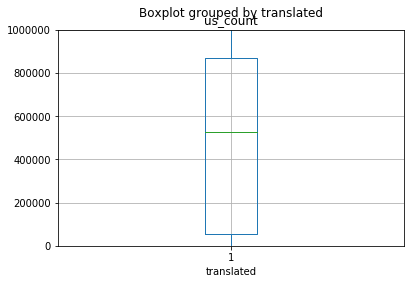

In [62]:
count_of_good_translations.boxplot(column='us_count', by='translated')
plt.ylim(ymax=1000000)
plt.ylim(ymin=0)
plt.show()

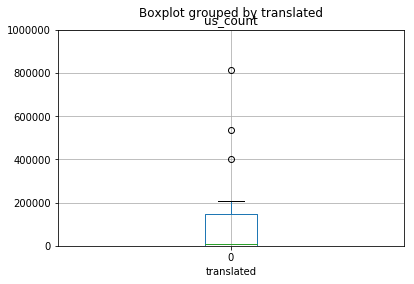

In [63]:
count_of_bad_translations.boxplot(column='us_count', by='translated')
plt.ylim(ymax=1000000)
plt.ylim(ymin=0)
plt.show()

Clearly, the words that were not translated properly had a low number of occurrences in the training data.